<a href="https://colab.research.google.com/github/stav-aizik/deep-learning-and-nlp-tesla-project/blob/main/Finalproject_StavAizik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries and download TSLA data


In [ ]:
#import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN , Dense , LSTM ,Dropout , GRU ,Flatten ,Bidirectional, Embedding, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop,SGD
from statsmodels.tsa.seasonal import seasonal_decompose
import re
from collections import Counter
from tensorflow.keras.layers import BatchNormalization
#tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
from textblob import TextBlob, Word
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Sequential

In [ ]:
#download data(tesla) from yahoo Finance
tsla = yf.download("TSLA",start="2021-09-01",end="2022-09-01")

[*********************100%***********************]  1 of 1 completed


In [ ]:
tsla.columns = [col[0] for col in tsla.columns]

In [ ]:
tsla

,Close,High,Low,Open,Volume
Date,,,,,
2021-09-01,244.696671,247.330002,243.756668,244.693329,39612900
2021-09-02,244.130005,246.990005,243.513336,244.833328,38331900
2021-09-03,244.523331,244.666672,241.399994,244.083328,45738300
2021-09-07,250.973328,253.399994,246.419998,246.666672,60119400
2021-09-08,251.289993,254.816666,246.923340,253.860001,56379000
...,...,...,...,...,...
2022-08-25,296.070007,302.959991,291.600006,302.359985,53230000
2022-08-26,288.089996,302.000000,287.470001,297.429993,57163900
2022-08-29,284.820007,287.739990,280.700012,282.829987,41864700


In [ ]:
tsla.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2021-09-01 to 2022-08-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   252 non-null    float64
 1   High    252 non-null    float64
 2   Low     252 non-null    float64
 3   Open    252 non-null    float64
 4   Volume  252 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 11.8 KB


#Downlowd elon_musk_tweets Dataset

In [ ]:
##download elon musk tweets dataset
#https://drive.google.com/file/d/1VO5RyMP4pm5vIbc3w4VPdX8HzPi_MyCC/view?usp=sharing
!gdown --fuzzy "https://drive.google.com/file/d/1VO5RyMP4pm5vIbc3w4VPdX8HzPi_MyCC/view?usp=sharing" -O elon_musk_tweets.zip
#unzip
!unzip elon_musk_tweets.zip -d elon_musk_tweets


Downloading...
From: https://drive.google.com/uc?id=1VO5RyMP4pm5vIbc3w4VPdX8HzPi_MyCC
To: /content/elon_musk_tweets.zip
100% 870k/870k [00:00<00:00, 90.2MB/s]
Archive:  elon_musk_tweets.zip
  inflating: elon_musk_tweets/elonmusk.csv  


In [ ]:
#read csv elon musk tweets
df=pd.read_csv("/content/elon_musk_tweets/elonmusk.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17437 entries, 0 to 17436
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date Created     17437 non-null  object
 1   Number of Likes  17437 non-null  int64 
 2   Source of Tweet  17437 non-null  object
 3   Tweets           17437 non-null  object
dtypes: int64(1), object(3)
memory usage: 545.0+ KB


In [ ]:
df

,Date Created,Number of Likes,Source of Tweet,Tweets
0,2022-09-12 05:44:11+00:00,1524,Twitter for iPhone,@teslaownersSV @cb_doge @Tesla @mayemusk I gue...
1,2022-09-12 05:43:02+00:00,19631,Twitter for iPhone,@cb_doge @Tesla @mayemusk Still doing same thi...
2,2022-09-12 04:19:57+00:00,9221,Twitter for iPhone,Looks good to roll out to all Tesla owners wit...
3,2022-09-12 03:25:03+00:00,944,Twitter for iPhone,@Tesla__Mania @WholeMarsBlog That is probably ...
4,2022-09-12 01:48:49+00:00,3710,Twitter for iPhone,@WholeMarsBlog Real-world validation &amp; bil...
...,...,...,...,...
17432,2011-12-03 08:22:07+00:00,51,Twitter for iPhone,That was a total non sequitur btw
17433,2011-12-03 08:20:28+00:00,53,Twitter for iPhone,"Great Voltaire quote, arguably better than Twa..."
17434,2011-12-01 10:29:04+00:00,75,Twitter Web Client,I made the volume on the Model S http://t.co/w...
17435,2011-12-01 09:55:11+00:00,189,Twitter Web Client,Went to Iceland on Sat to ride bumper cars on ...


Creates a new DataFrame elon_df with just the tweet text and creation date.

In [ ]:
elon_df = df[['Date Created', 'Tweets']].copy()

In [ ]:
#create a Date column - datetime type
elon_df['Date'] = pd.to_datetime(df['Date Created'])

In [ ]:
#Selection of a relevant date
start_date = pd.to_datetime('2021-09-01').tz_localize('UTC')
end_date = pd.to_datetime('2022-09-01').tz_localize('UTC')

elon_df = elon_df[(elon_df['Date'] >= start_date) & (elon_df['Date'] < end_date)]


In [ ]:
elon_df

,Date Created,Tweets,Date
80,2022-08-31 15:39:27+00:00,@ChrisZheng001 I intend to do so as soon as po...,2022-08-31 15:39:27+00:00
81,2022-08-31 15:16:57+00:00,@teslaownersSV 🤣,2022-08-31 15:16:57+00:00
82,2022-08-31 15:13:23+00:00,"@SciGuySpace Yeah, aiming for up to 100 flight...",2022-08-31 15:13:23+00:00
83,2022-08-31 15:06:53+00:00,Now launching every ~5 days,2022-08-31 15:06:53+00:00
84,2022-08-30 22:52:58+00:00,@WholeMarsBlog @jonbbc @aelluswamy 10.69.2 goe...,2022-08-30 22:52:58+00:00
...,...,...,...
3737,2021-09-01 16:46:52+00:00,@DJSnM @thesheetztweetz @johnkrausphotos @Lyla...,2021-09-01 16:46:52+00:00
3738,2021-09-01 16:42:32+00:00,@DJSnM @thesheetztweetz @johnkrausphotos @Lyla...,2021-09-01 16:42:32+00:00
3739,2021-09-01 16:21:41+00:00,@thesheetztweetz Filing legal actions against ...,2021-09-01 16:21:41+00:00
3740,2021-09-01 16:13:33+00:00,@SciGuySpace He should consider spending some ...,2021-09-01 16:13:33+00:00


#Statistical Data - TSLA

In [ ]:
#describe
tsla.describe()

,Close,High,Low,Open,Volume
count,252.000000,252.000000,252.000000,252.000000,2.520000e+02
mean,296.773651,304.358889,289.330211,297.211839,8.012612e+07
std,47.546290,48.915248,46.225322,47.989156,2.608064e+07
min,209.386673,217.973328,206.856674,207.949997,3.504270e+07
25%,255.262497,261.730003,249.826668,255.566669,6.192960e+07
50%,292.128342,301.179993,285.813339,295.166672,7.710210e+07
75%,336.472504,344.957512,327.908340,335.700005,9.351338e+07
max,409.970001,414.496674,405.666656,411.470001,1.885563e+08


statistical by months:

In [ ]:
tsla['month']=tsla.index.to_period('M')

In [ ]:
#GroupBy Monthe
group_month = tsla.groupby('month')

In [ ]:
group_month.mean()

,Close,High,Low,Open,Volume
month,,,,,
2021-09,251.317463,253.858095,247.543493,250.604284,5.573876e+07
2021-10,292.783017,296.909206,287.247936,289.953491,7.556209e+07
2021-11,373.554125,382.863017,362.036666,372.588890,9.273021e+07
2021-12,339.629999,348.253938,330.886665,341.477726,6.955308e+07
2022-01,336.722830,349.012334,326.520500,339.770000,9.580032e+07
2022-02,292.961577,301.286843,284.898768,292.789474,7.321719e+07
2022-03,304.793186,311.332608,296.599713,303.253333,7.518578e+07
2022-04,332.462503,344.035336,325.974168,337.054169,7.604799e+07
2022-05,255.223333,264.414288,246.076190,256.985554,9.277246e+07


In [ ]:
group_month.describe()

Close                                                             \
        count        mean        std         min         25%         50%   
month                                                                      
2021-09  21.0  251.317463   5.874000  243.389999  246.460007  251.213333   
2021-10  21.0  292.783017  36.500997  258.406677  263.980011  281.010010   
2021-11  21.0  373.554125  22.071917  337.796661  355.983337  372.000000   
2021-12  22.0  339.629999  20.612209  299.980011  322.934990  338.666672   
2022-01  20.0  336.722830  31.675523  276.366669  312.412498  342.911667   
2022-02  19.0  292.961577  16.457416  254.679993  286.163330  297.046661   
2022-03  23.0  304.793186  36.075913  255.456665  279.431656  290.533325   
2022-04  20.0  332.462503  24.950996  290.253326  325.627502  334.889999   
2022-05  21.0  255.223333  29.855613  209.386673  236.473328  252.753326   
2022-06  21.0  234.025873  11.247435  213.100006  228.490005  235.070007   
2022-07  20.0  251.394666  19.678442  227.263336  236.365829  245.036667   
2022-08  23.0  294.869857   9.581290  275.609985  288.130005  296.453339   

                                 High              ...        Open  \
                75%         max count        mean  ...         75%   
month                                              ...               
2021-09  253.163330  263.786682  21.0  253.858095  ...  253.199997   
2021-10  303.226654  371.333344  21.0  296.909206  ...  298.500000   
2021-11  387.646667  409.970001  21.0  382.863017  ...  387.443329   
2021-12  356.665001  365.000000  22.0  348.253938  ...  357.870842   
2022-01  354.824989  399.926666  20.0  349.012334  ...  359.743332   
2022-02  307.404999  310.666656  19.0  301.286843  ...  304.551666   
2022-03  334.958344  366.523346  23.0  311.332608  ...  331.323334   
2022-04  344.184174  381.816681  20.0  344.035336  ...  352.553329   
2022-05  266.679993  317.540009  21.0  264.414288  ...  278.816681   
2022-06  239.706665  258.333344  21.0  241.544444  ...  244.156662   
2022-07  269.251656  297.149994  20.0  255.841666  ...  264.485832   
2022-08  301.728333  309.320007  23.0  301.852028  ...  302.514999   

                    Volume                                          \
                max  count          mean           std         min   
month                                                                
2021-09  262.399994   21.0  5.573876e+07  1.501086e+07  35842500.0   
2021-10  360.619995   21.0  7.556209e+07  4.273815e+07  36741600.0   
2021-11  411.470001   21.0  9.273021e+07  3.539410e+07  35042700.0   
2021-12  386.899994   22.0  6.955308e+07  1.685216e+07  40733700.0   
2022-01  396.516663   20.0  9.580032e+07  2.463356e+07  66063300.0   
2022-02  311.736664   19.0  7.321719e+07  2.039672e+07  50729100.0   
2022-03  369.329987   23.0  7.518578e+07  1.744512e+07  48992700.0   
2022-04  378.766663   20.0  7.604799e+07  2.373524e+07  49847700.0   
2022-05  313.006653   21.0  9.277246e+07  1.905685e+07  63709500.0   
2022-06  251.720001   21.0  9.577276e+07  1.320167e+07  72808500.0   
2022-07  280.700012   20.0  8.724420e+07  1.724209e+07  64073400.0   
2022-08  311.666656   23.0  7.370710e+07  2.127902e+07  41864700.0   

                                                           
                25%         50%          75%          max  
month                                                      
2021-09  45378900.0  53868000.0   64119000.0   84612600.0  
2021-10  50215800.0  57587400.0   89755200.0  188556300.0  
2021-11  67189800.0  81276000.0  104326800.0  177317400.0  
2021-12  57219675.0  70976100.0   80896125.0  100437300.0  
2022-01  78950475.0  91075800.0  104057550.0  151565700.0  
2022-02  59140350.0  68501700.0   79250700.0  135322200.0  
2022-03  64307250.0  71152200.0   81190350.0  120676200.0  
2022-04  57597000.0  70203900.0   83560200.0  136133700.0  
2022-05  84401700.0  89295000.0   92519100.0  144973200.0  
2022-06  89178300.0  95770800.0  102767400.0 

In [ ]:
# just the Close price statistics from the grouped monthly data
Close = group_month.describe()['Close'][['max','min','mean']]

<function matplotlib.pyplot.show(close=None, block=None)>

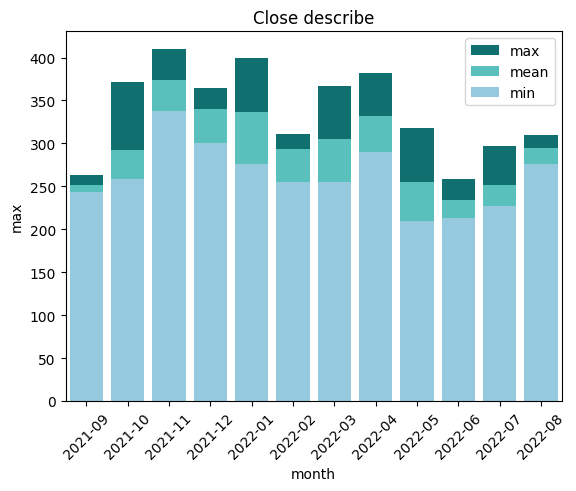

In [ ]:
#close describe
plt.title('Close describe')
sns.barplot(x='month',y='max' , data = Close , color= 'teal',label = 'max')
sns.barplot(x='month',y='mean' , data = Close, color= 'mediumturquoise',label = 'mean')
sns.barplot(x='month',y='min' , data = Close , color= 'skyblue',label = 'min')
plt.xticks(rotation=45)
plt.show

In [ ]:
Volume = group_month.describe()['Volume'][['max','min','mean']]

<function matplotlib.pyplot.show(close=None, block=None)>

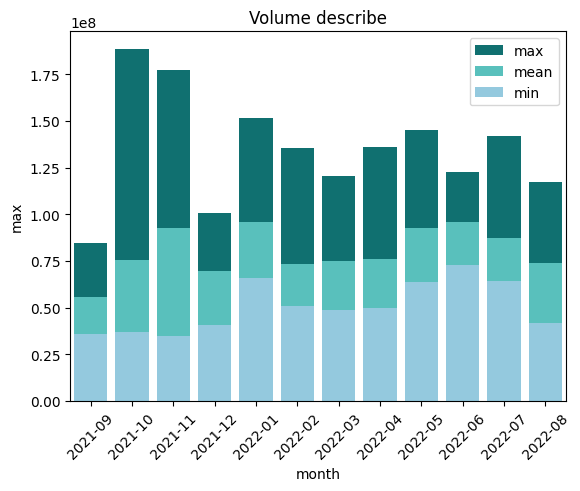

In [ ]:
#Volume describe
plt.title('Volume describe')
sns.barplot(x='month',y='max' , data = Volume , color= 'teal',label = 'max')
sns.barplot(x='month',y='mean' , data = Volume, color= 'mediumturquoise',label = 'mean')
sns.barplot(x='month',y='min' , data = Volume , color= 'skyblue',label = 'min')
plt.xticks(rotation=45)
plt.show

statistical by day of week:

In [ ]:
tsla['day of week']=tsla.index.day_of_week

In [ ]:
group_day=tsla.groupby('day of week')

In [ ]:
tsla.head(1)

,Close,High,Low,Open,Volume,month,day of week
Date,,,,,,,
2021-09-01,244.696671,247.330002,243.756668,244.693329,39612900,2021-09,2


In [ ]:
group_day.describe()

Close                                                             \
            count        mean        std         min         25%         50%   
day of week                                                                    
0            46.0  302.160871  50.483449  215.736664  262.724167  298.628342   
1            52.0  296.813972  48.088550  209.386673  257.612488  294.296677   
2            53.0  297.298490  48.358046  219.600006  251.289993  294.356659   
3            51.0  294.653399  46.424061  213.100006  255.331673  291.093323   
4            50.0  293.381800  45.910999  216.759995  256.930000  288.130005   

                                     High              ...        Open  \
                    75%         max count        mean  ...         75%   
day of week                                            ...               
0            335.943336  402.863342  46.0  309.016450  ...  332.419174   
1            339.899155  390.666656  52.0  305.298782  ...  334.582504   
2            336.290009  404.619995  53.0  304.294717  ...  336.803345   
3            335.430008  409.970001  51.0  303.314902  ...  336.576660   
4            336.414169  407.363342  50.0  300.229334  ...  336.187500   

                        Volume                                          \
                    max  count          mean           std         min   
day of week                                                              
0            387.443329   46.0  8.644927e+07  2.850052e+07  41864700.0   
1            396.516663   52.0  8.194073e+07  2.831693e+07  48992100.0   
2            392.443329   53.0  7.621656e+07  2.228186e+07  39612900.0   
3            411.470001   51.0  7.868475e+07  2.771287e+07  35842500.0   
4            409.333344   50.0  7.803595e+07  2.300007e+07  35042700.0   

                                                              
                    25%         50%         75%          max  
day of week                                                   
0            69429600.0  83371050.0  99164850.0  188556300.0  
1            65478225.0  77885700.0  88375425.0  187245000.0  
2            57259800.0  76210500.0  92139300.0  128408100.0  
3            58535400.0  76192200.0  93958800.0  147109500.0  
4            62553450.0  74042850.0  92561850.0  144973200.0  

[5 rows x 40 columns]

In [ ]:
Close_day = group_day.describe()['Close'][['max','min','mean']]

In [ ]:
#Close day - Max,Min,Mean
Close_day

,max,min,mean
day of week,,,
0,402.863342,215.736664,302.160871
1,390.666656,209.386673,296.813972
2,404.619995,219.600006,297.298490
3,409.970001,213.100006,294.653399
4,407.363342,216.759995,293.381800


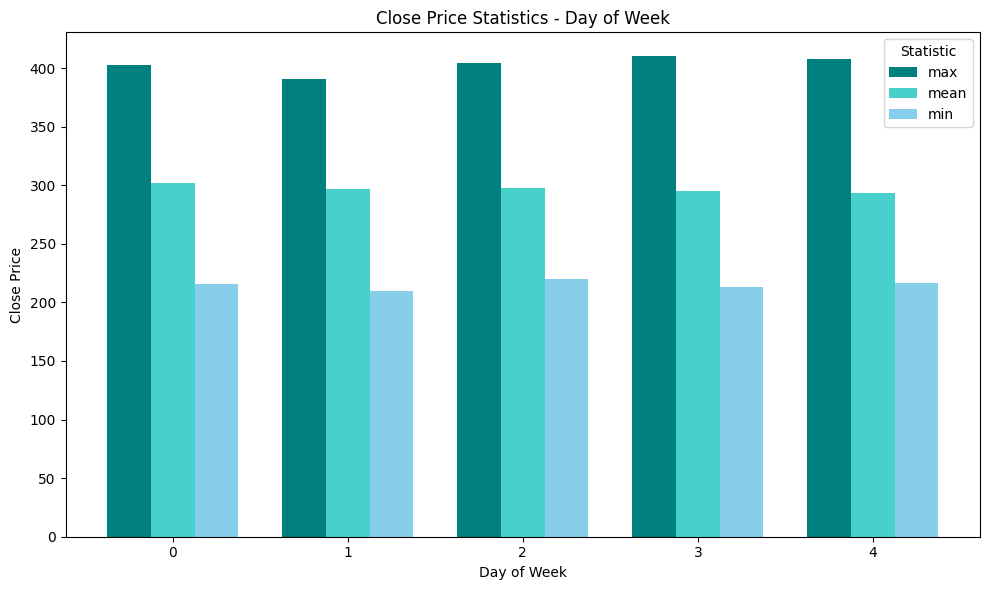

In [ ]:
days = Close_day.index
max_values = Close_day['max']
mean_values = Close_day['mean']
min_values = Close_day['min']

x = np.arange(len(days))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, max_values, width, label='max', color='teal')
plt.bar(x, mean_values, width, label='mean', color='mediumturquoise')
plt.bar(x + width, min_values, width, label='min', color='skyblue')

plt.title('Close Price Statistics - Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Close Price')
plt.legend(title='Statistic')

plt.tight_layout()
plt.show()


heatmap:

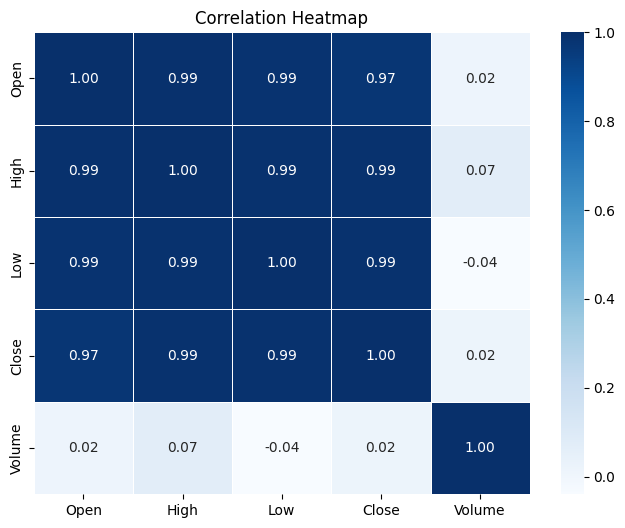

In [ ]:
#correlation matrix
correlation_matrix = tsla[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', linewidths=0.5, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

<Axes: xlabel='Close', ylabel='High'>

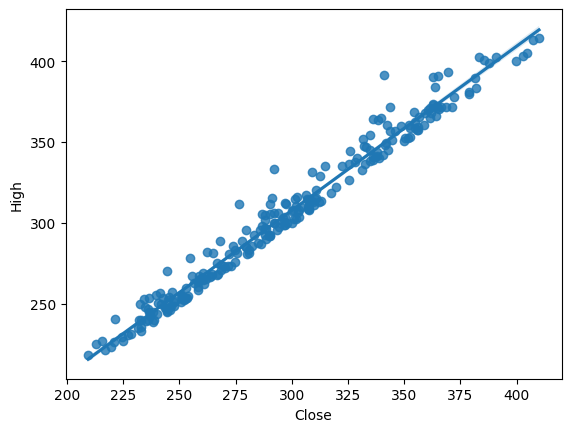

In [ ]:
sns.regplot(x='Close' , y='High' , data = tsla)

<Axes: xlabel='Close', ylabel='Open'>

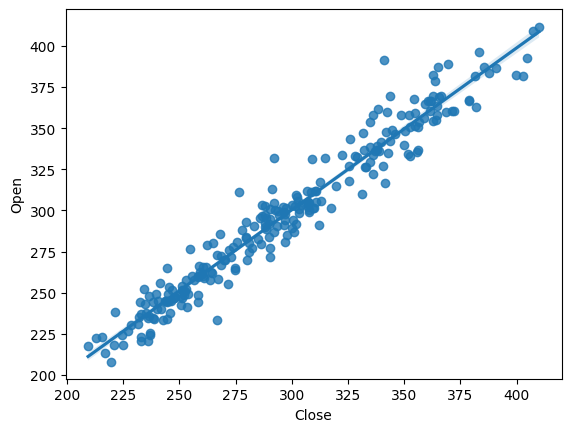

In [ ]:
sns.regplot(x='Close' , y='Open' , data = tsla)

In [ ]:
# Adds a 'Quarter' column
tsla['Quarter'] = tsla.index.to_period('Q')

# Takes the first row of each quarter group
quarter_start = tsla.groupby('Quarter').head(1)

quarter_start[['Open', 'High', 'Low', 'Close', 'Volume']]

,Open,High,Low,Close,Volume
Date,,,,,
2021-09-01,244.693329,247.330002,243.756668,244.696671,39612900
2021-10-01,259.466675,260.260010,254.529999,258.406677,51094200
2022-01-03,382.583344,400.356659,378.679993,399.926666,103931400
2022-04-01,360.383331,364.916656,355.546661,361.529999,54263100
2022-07-01,227.000000,230.229996,222.119995,227.263336,74460300


In [ ]:
quarter_start

,Close,High,Low,Open,Volume,month,day of week,Quarter
Date,,,,,,,,
2021-09-01,244.696671,247.330002,243.756668,244.693329,39612900,2021-09,2,2021Q3
2021-10-01,258.406677,260.260010,254.529999,259.466675,51094200,2021-10,4,2021Q4
2022-01-03,399.926666,400.356659,378.679993,382.583344,103931400,2022-01,0,2022Q1
2022-04-01,361.529999,364.916656,355.546661,360.383331,54263100,2022-04,4,2022Q2
2022-07-01,227.263336,230.229996,222.119995,227.000000,74460300,2022-07,4,2022Q3


In [ ]:
volum_quarter = quarter_start.Volume

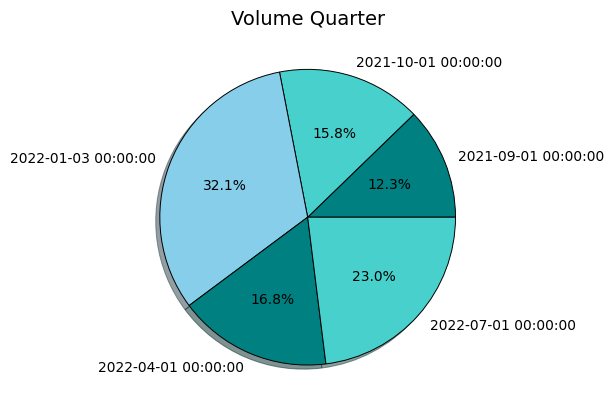

In [ ]:
#pie chart of quarterly trading volumes
plt.title('Volume Quarter', fontsize=14)
plt.pie(volum_quarter,labels = volum_quarter.index,
        wedgeprops = {'edgecolor' :'k',
                      'linewidth': 0.7} ,
        shadow = True ,
        colors = ['teal', 'mediumturquoise', 'skyblue'],
       autopct='%1.1f%%',
        )

plt.show()


In [ ]:
max_date=tsla['Close'].idxmax()
min_date=tsla['Close'].idxmin()
highlight_dates = [tsla['Close'].idxmax(),tsla['Close'].idxmin()]
highlight_values = tsla.loc[highlight_dates, 'Close']

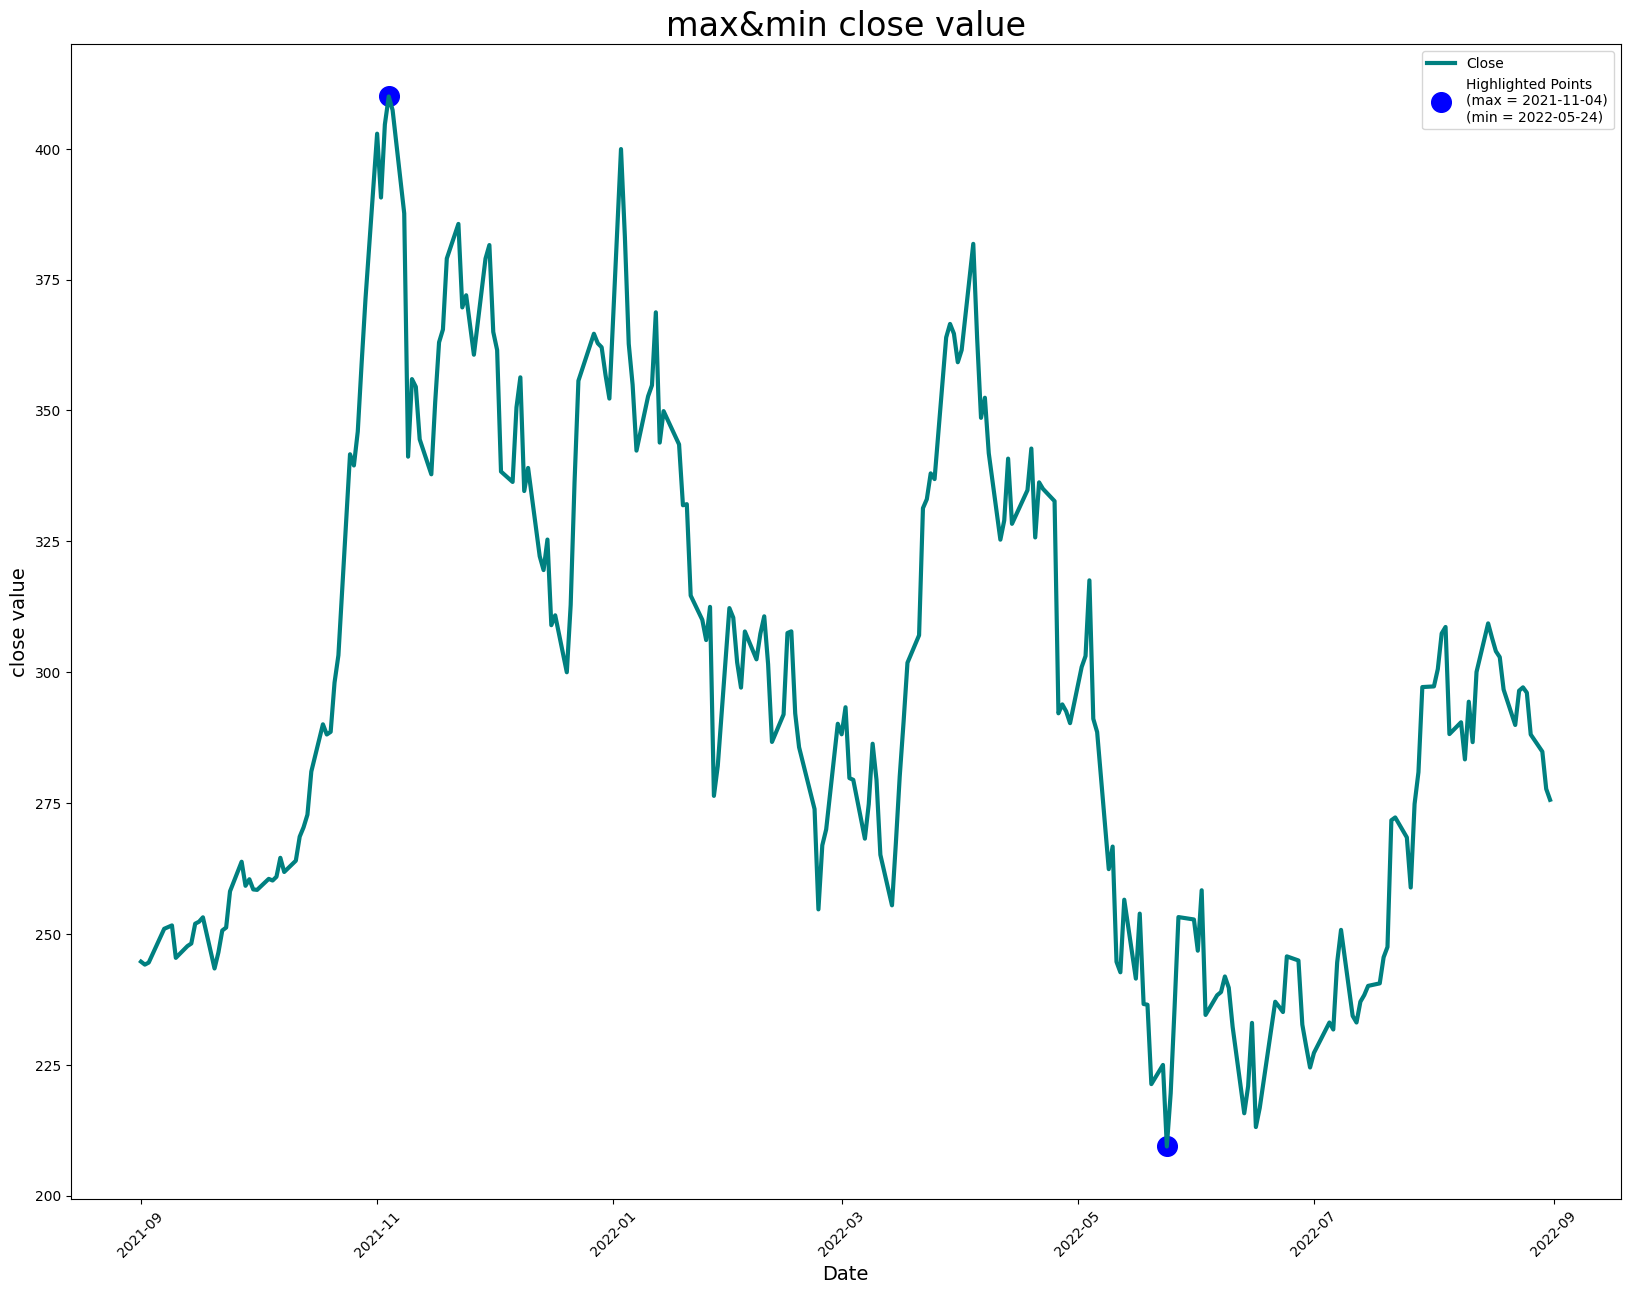

In [ ]:
#
plt.subplots(figsize=(20,15))
plt.title('max&min close value',fontsize=24)
sns.lineplot(x='Date',y='Close' , data = tsla , linewidth=3, color= 'teal',label = 'Close')
plt.xlabel('Date',fontsize=14)
plt.ylabel('close value',fontsize=14)
plt.xticks(rotation=45)

plt.scatter(highlight_dates, highlight_values, color='blue', s=200,
            label=f'Highlighted Points\n(max = {max_date.date()})\n(min = {min_date.date()})')
plt.legend()
plt.show()

In [ ]:
group_day.describe()['Close'][['mean']]

,mean
day of week,
0,302.160871
1,296.813972
2,297.298490
3,294.653399
4,293.381800


In [ ]:
close_d_mean = group_day.describe()['Close'][['mean']]

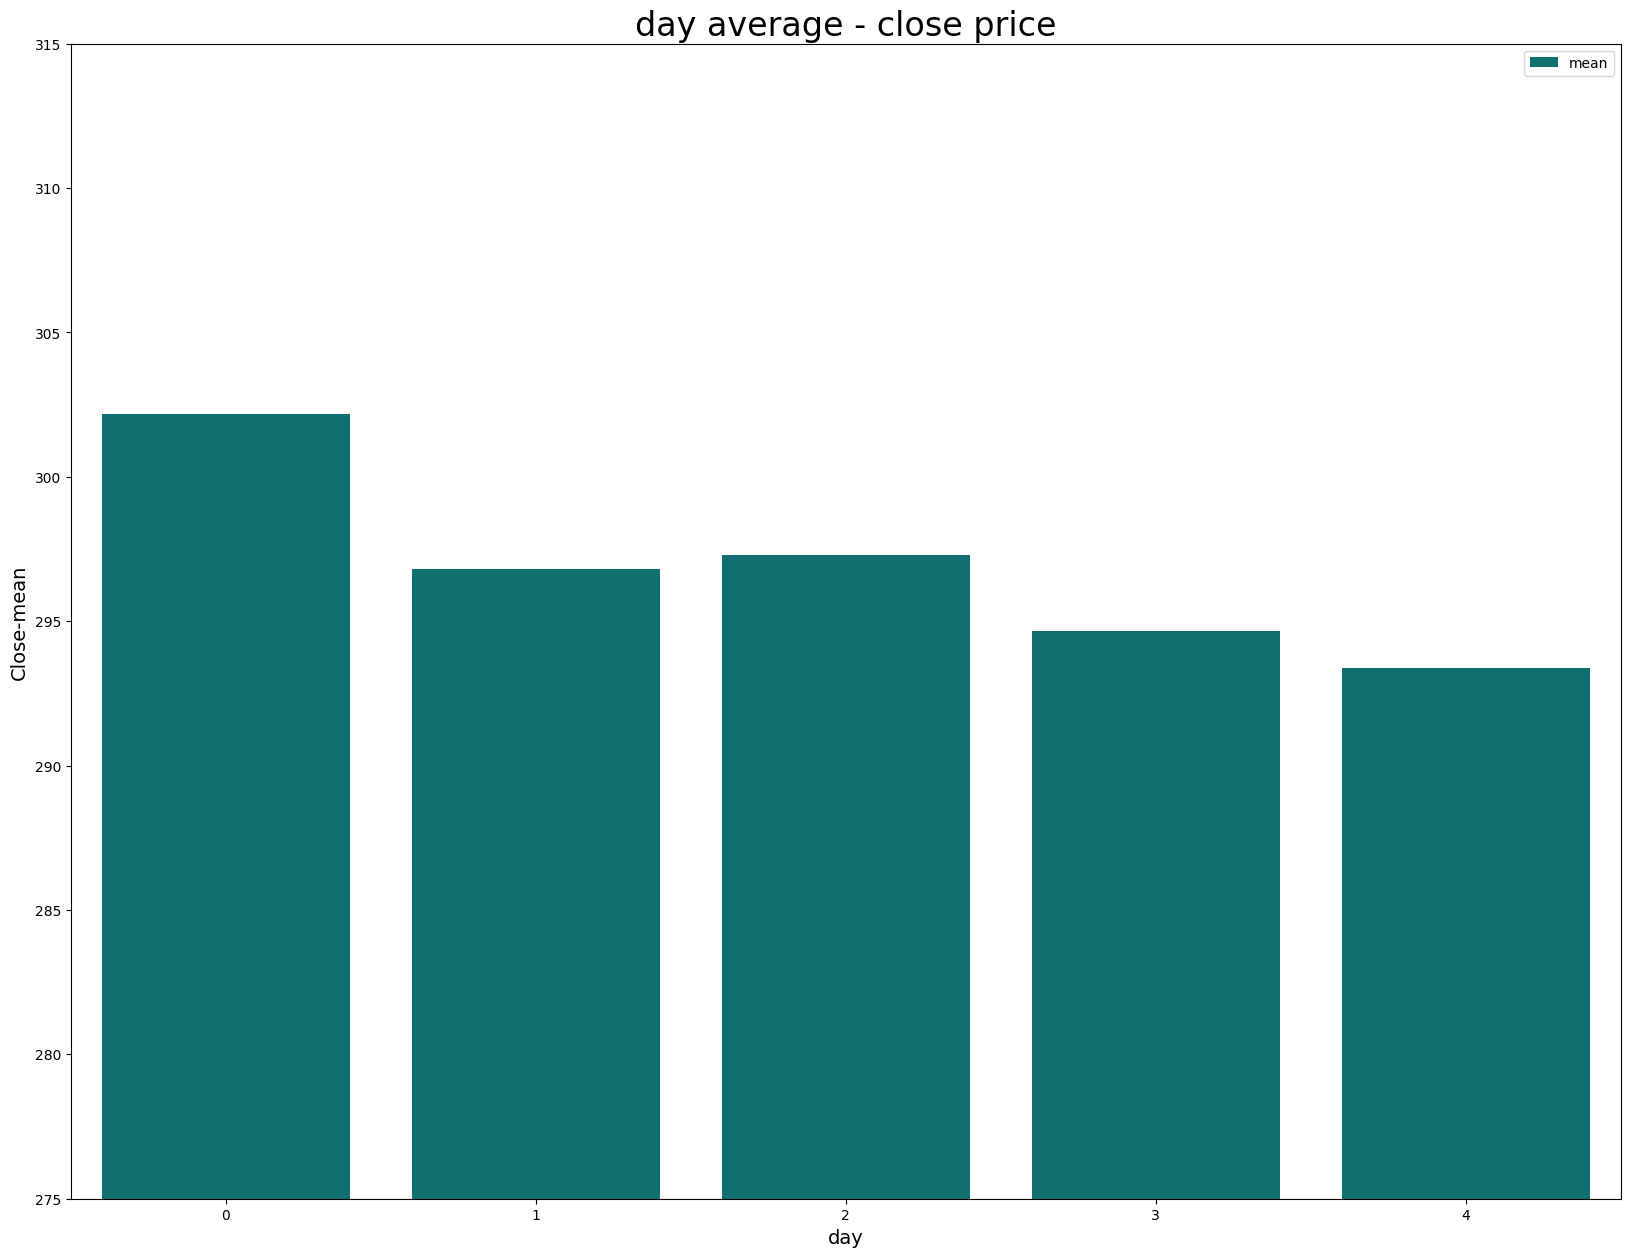

In [ ]:
plt.subplots(figsize=(20,15))
plt.title('day average - close price',fontsize=24)
sns.barplot(x='day of week',y='mean' , data = close_d_mean , color= 'teal',label = 'mean')
plt.ylim(275,315)
plt.xlabel('day',fontsize=14)
plt.ylabel('Close-mean',fontsize=14)
plt.xticks(rotation=0)
plt.show()

In [ ]:
close_m_mean = group_month.describe()['Close'][['mean']]

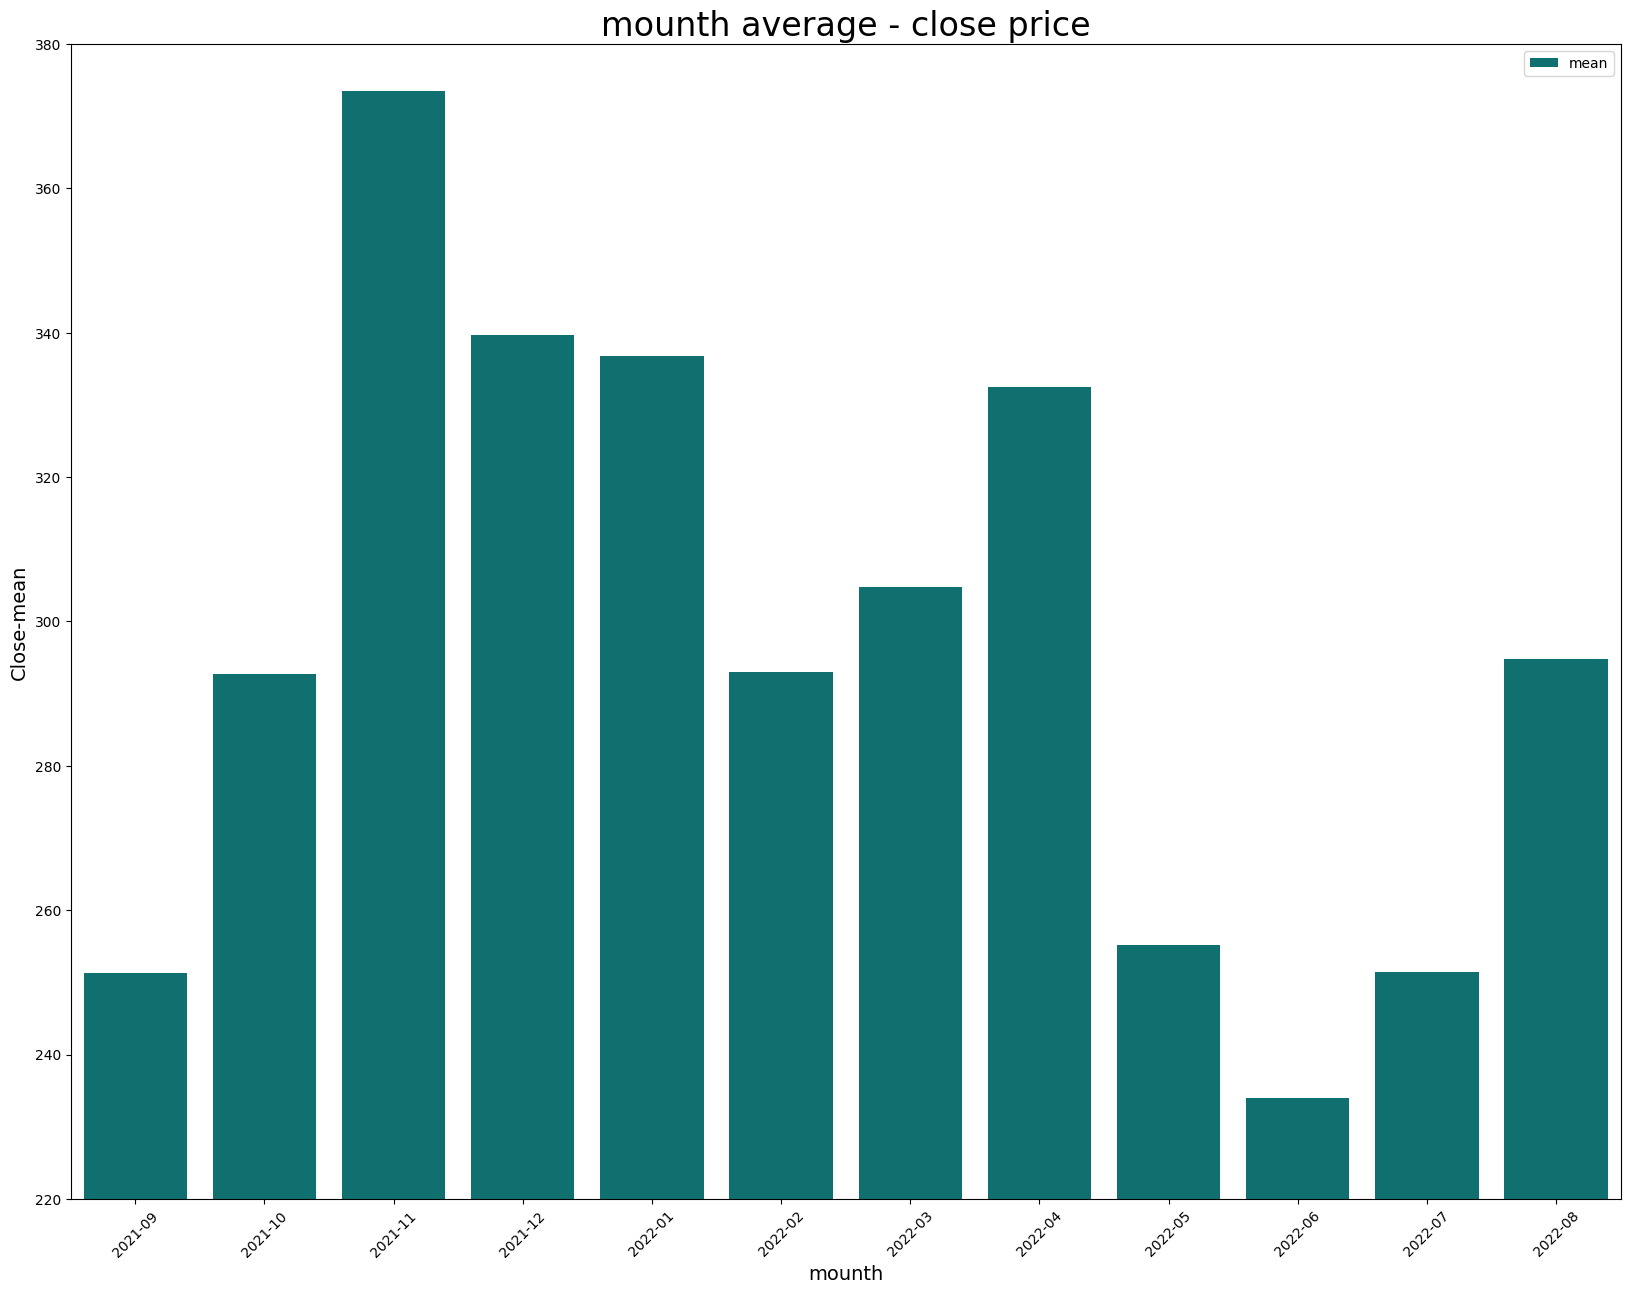

In [ ]:
plt.subplots(figsize=(20,15))
plt.title('mounth average - close price',fontsize=24)
sns.barplot(x='month',y='mean' , data = close_m_mean , color= 'teal',label = 'mean')
plt.ylim(220,380)
plt.xlabel('mounth',fontsize=14)
plt.ylabel('Close-mean',fontsize=14)
plt.xticks(rotation=45)
plt.show()

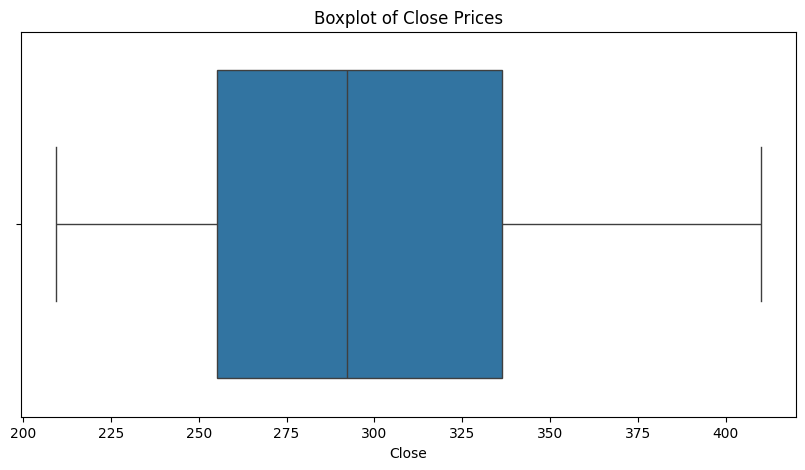

In [ ]:
#Boxplot of Close prices – shows median, quartiles, and outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=tsla['Close'])
plt.title("Boxplot of Close Prices")
plt.show()

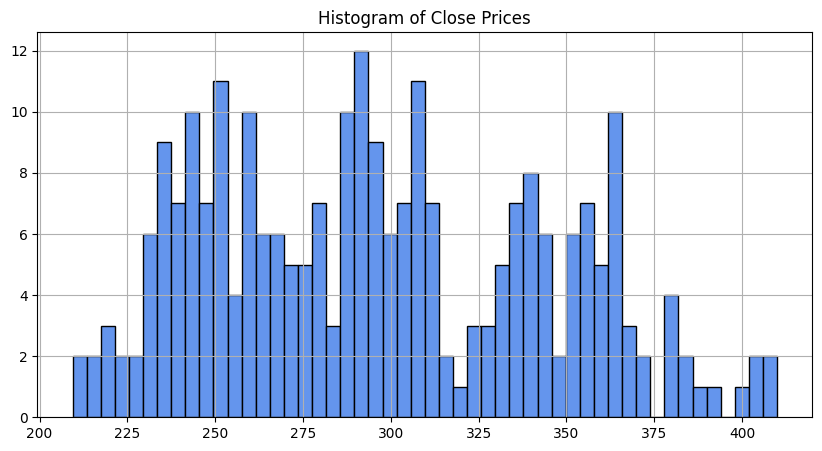

In [ ]:
# Histogram to visualize distribution of Close prices
tsla['Close'].hist(bins=50,color='cornflowerblue', edgecolor='black', figsize=(10, 5))
plt.title("Histogram of Close Prices")
plt.show()

In [ ]:
Q1 = tsla['Close'].quantile(0.25)
Q3 = tsla['Close'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = tsla[(tsla['Close'] < lower_bound) | (tsla['Close'] > upper_bound)]
print(outliers_iqr[['Close']])

Empty DataFrame
Columns: [Close]
Index: []


#Pre-processing - TSLA

In [ ]:
#Drops unnecessary columns
tsla.drop(['month','day of week','Quarter'],axis=1,inplace=True)

In [ ]:
pd.concat([tsla["Close"],
           tsla["Close"].shift(-1),
           tsla["Close"].shift(+1)],
          keys = ["Close","tmw", "yesteday"], axis =1).head()

,Close,tmw,yesteday
Date,,,
2021-09-01,244.696671,244.130005,NaN
2021-09-02,244.130005,244.523331,244.696671
2021-09-03,244.523331,250.973328,244.130005
2021-09-07,250.973328,251.289993,244.523331
2021-09-08,251.289993,251.619995,250.973328


In [ ]:
#calculating the daily change
tsla["Change"] = (tsla["Close"].shift(-1)- tsla["Close"])

In [ ]:
#Assigns binary labels
tsla.loc[tsla["Change"] >0, "label"]= 1
#tsla.loc[tsla["Change"] <0, "label"]= -1
tsla.loc[tsla["Change"] <0, "label"]= 0

In [ ]:
tsla

,Close,High,Low,Open,Volume,Change,label
Date,,,,,,,
2021-09-01,244.696671,247.330002,243.756668,244.693329,39612900,-0.566666,0.0
2021-09-02,244.130005,246.990005,243.513336,244.833328,38331900,0.393326,1.0
2021-09-03,244.523331,244.666672,241.399994,244.083328,45738300,6.449997,1.0
2021-09-07,250.973328,253.399994,246.419998,246.666672,60119400,0.316666,1.0
2021-09-08,251.289993,254.816666,246.923340,253.860001,56379000,0.330002,1.0
...,...,...,...,...,...,...,...
2022-08-25,296.070007,302.959991,291.600006,302.359985,53230000,-7.980011,0.0
2022-08-26,288.089996,302.000000,287.470001,297.429993,57163900,-3.269989,0.0
2022-08-29,284.820007,287.739990,280.700012,282.829987,41864700,-7.119995,0.0


In [ ]:
tsla = tsla.dropna(subset=['label'])

In [ ]:
#Defining features , target & train , test
split_index = int(len(tsla) * 0.8)
train = tsla.iloc[:split_index]
test = tsla.iloc[split_index:]
features=['Close','High','Low','Open','Volume']
target = 'label'

In [ ]:
#split train & test
X_train=train[features]
X_test=test[features]
y_train=train[target]
y_test=test[target]

#Classic models

In [ ]:
#scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#Defining models
models = {

    "Logistic Regression": LogisticRegression(max_iter=50, C=0.001, random_state=42,class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=5, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=6, min_samples_leaf=5, random_state=42),
    "SVM": SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
}


In [ ]:
print(tsla['label'].value_counts(normalize=True))

label
1.0    0.541833
0.0    0.458167
Name: proportion, dtype: float64


In [ ]:

# Initialize results list
results = []

# Loop over models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)

    # Append to results list
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "Confusion Matrix": conf
    })

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:22:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
results_df = pd.DataFrame(results).drop(columns=['Confusion Matrix'])
results_df.sort_values(by='F1-score', ascending=False)

,Model,Accuracy,Precision,Recall,F1-score
1,Random Forest,0.568627,0.555556,0.925926,0.694444
3,SVM,0.529412,0.529412,1.000000,0.692308
5,XGBoost,0.607843,0.594595,0.814815,0.687500
0,Logistic Regression,0.549020,0.543478,0.925926,0.684932
2,Decision Tree,0.549020,0.576923,0.555556,0.566038
4,KNN,0.549020,0.576923,0.555556,0.566038


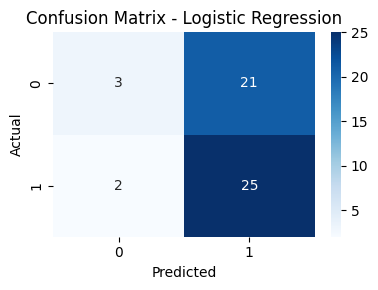

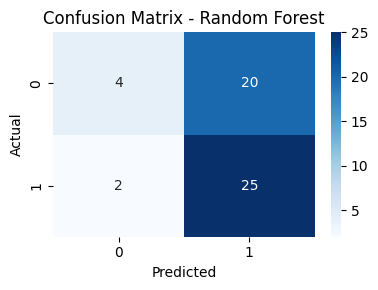

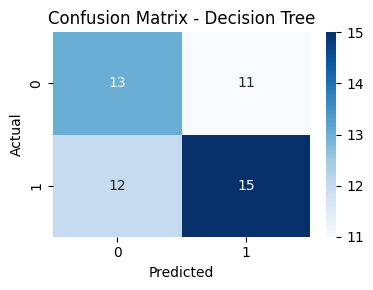

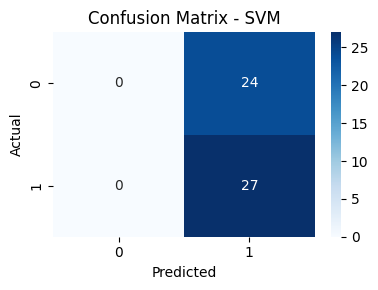

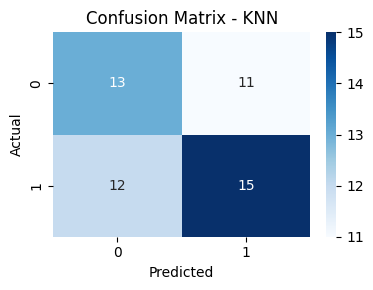

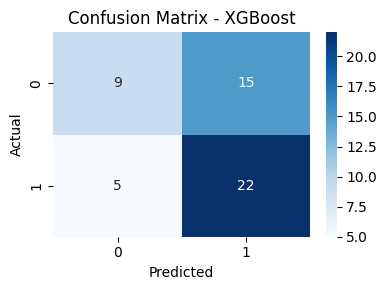

In [ ]:
for result in results:
    plt.figure(figsize=(4,3))
    sns.heatmap(result['Confusion Matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {result['Model']}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

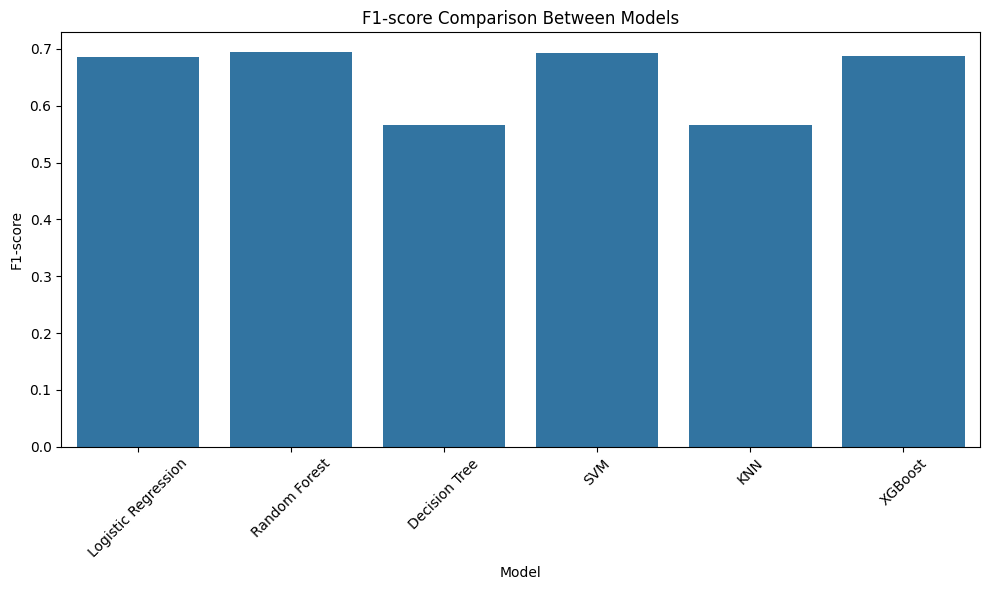

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x='Model', y='F1-score')
plt.title('F1-score Comparison Between Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#LSTM

In [ ]:
Close_prices = tsla[['Close']].values

In [ ]:
split_index = int(len(Close_prices)*0.8)

In [ ]:
train_data = Close_prices[:split_index]
test_data=Close_prices[split_index:]

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [ ]:
def create_sequences(data,window_size):
  X,y = [],[]
  for i in range(len(data)-window_size):
    X.append(data[i:i+window_size])
    y.append(data[i + window_size])
  return np.array(X) , np.array(y)

In [ ]:
window_size = 12
X_train , y_train = create_sequences(train_scaled,window_size)
X_test,y_test = create_sequences(test_scaled,window_size)

In [ ]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [ ]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window_size, 1)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#model.compile(loss="mae", optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))

In [ ]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

In [ ]:
history = model.fit(
    X_train,y_train,
    validation_data=(X_test,y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.3770 - val_loss: 0.1850 - learning_rate: 0.0010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1425 - val_loss: 0.1674 - learning_rate: 0.0010
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1253 - val_loss: 0.1599 - learning_rate: 0.0010
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1134 - val_loss: 0.1644 - learning_rate: 0.0010
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0711 - val_loss: 0.1424 - learning_rate: 0.0010
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0981 - val_loss: 0.1484 - learning_rate: 0.0010
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0547 - val_loss: 0.1710 - learning_rate: 0.0010
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0501 - val_loss: 0.1522 - learning_rate: 0.0010
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0513 - val_loss: 0.1511 - learning_rate: 0.0010
Epoch 10/1

In [ ]:
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


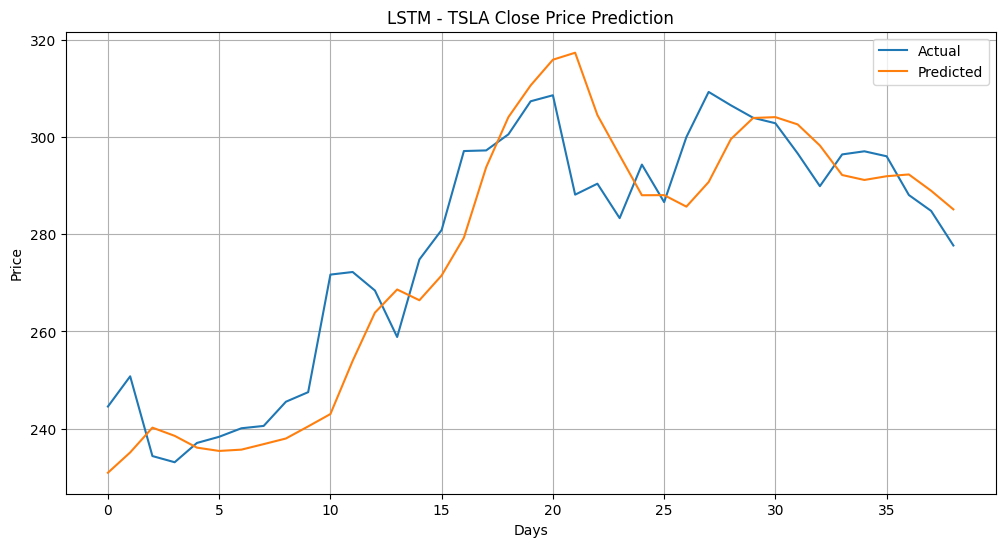

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('LSTM - TSLA Close Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
y_pred_adj = y_pred_inv[1:]
y_test_adj = y_test_inv[:-1]


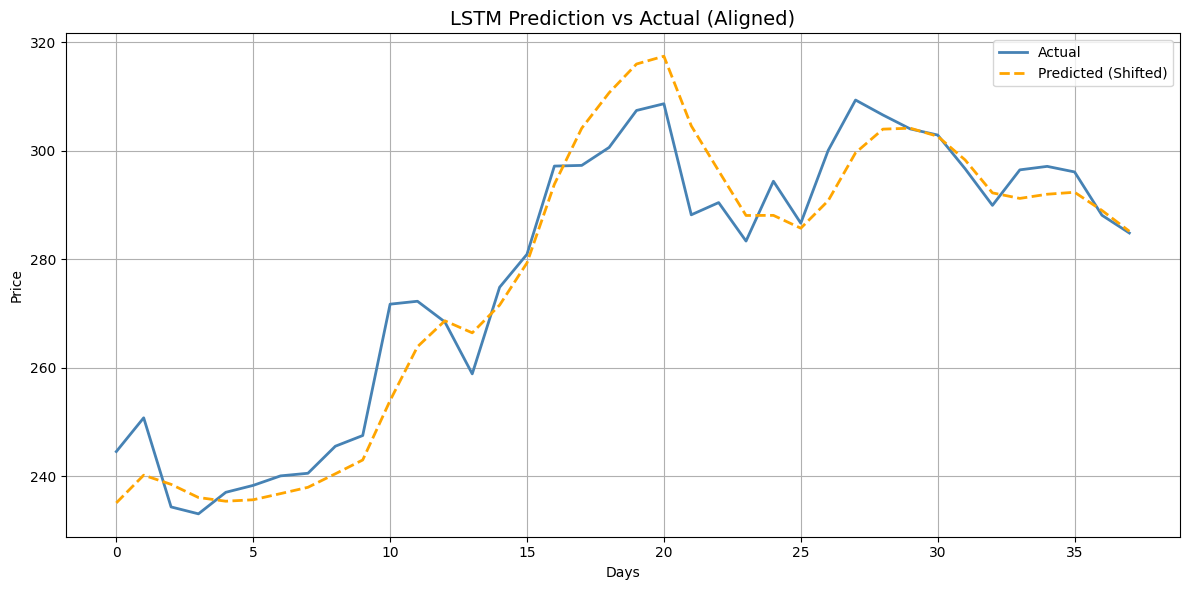

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_adj, label='Actual', color='steelblue', linewidth=2)
plt.plot(y_pred_adj, label='Predicted (Shifted)', color='orange', linestyle='--', linewidth=2)
plt.title('LSTM Prediction vs Actual (Aligned)', fontsize=14)
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


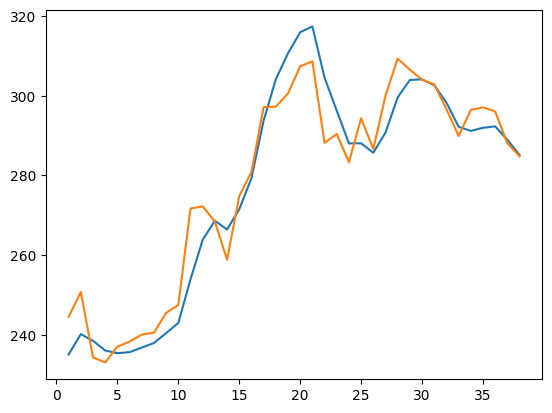

In [ ]:
plt.plot(range(1, len(y_pred_adj)+1), y_pred_adj, label='Predicted')
plt.plot(range(1, len(y_test_adj)+1), y_test_adj, label='Actual')


In [ ]:
print("Scaled y_pred range:", y_pred.min(), y_pred.max())
print("Unscaled y_pred range:", y_pred_inv.min(), y_pred_inv.max())


Scaled y_pred range: -0.7853834 0.07693176
Unscaled y_pred range: 230.91092 317.39395


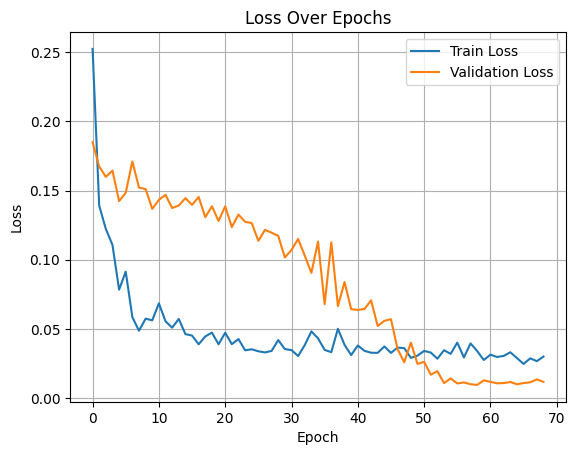

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print("Training samples:", X_train.shape[0])


Training samples: 188


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


MAE: 8.50
RMSE: 10.88
R²: 0.80


#EDA-TWEETS

**clean tweet:**

In [ ]:
def clean_tweet(text):
    if pd.isnull(text):
        return ""
    text = text.lower()                           # Converting to lowercase
    text = re.sub(r"http\S+|https\S+", "", text)  # Removing URLs, mentions, hashtags
    text = re.sub(r"@\w+|#\w+", "", text)         # Remove @mentions and #hashtags using regex
    text = re.sub(r"[^a-zA-Z\s]", "", text)       # Remove any characters that are not letters
    text = re.sub(r"\s+", " ", text).strip()      # Replace multiple spaces
    return text

Apply the clean_tweet() function to every row in the 'Tweets' column:

In [ ]:
elon_df['Cleaned_Tweet'] = elon_df['Tweets'].apply(clean_tweet)
elon_df['Date'] = elon_df['Date'].dt.date

In [ ]:
#Group tweets by date
daily_tweets = elon_df.groupby('Date')['Cleaned_Tweet'].apply(lambda x: ' '.join(x)).reset_index()

In [ ]:
daily_tweets

,Date,Cleaned_Tweet
0,2021-09-01,i was in the berlin paint shop talking to th...
1,2021-09-02,im fkn tryin ur welcome pls be nice to the hum...
2,2021-09-03,this is obv debatable but id call anything wit...
3,2021-09-04,lot of good work happening on tesla sound code...
4,2021-09-06,impressive worth it many times thats one of my...
...,...,...
333,2022-08-27,the caffeine one is most troubling
334,2022-08-28,this will happen again just a matter of time g...
335,2022-08-29,it will grow by at least to meters over time f...
336,2022-08-30,goes out to k owners next week sjm question sp...


In [ ]:
#Delete English stopwords (like: the, is, on)
nltk.download('stopwords')
all_words = ' '.join(daily_tweets['Cleaned_Tweet']).lower().split()
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in all_words if word not in stop_words and len(word) > 2]
#Counts how many times each word appears
word_freq = Counter(filtered_words)
#Gets the 20 most frequent words
common_words = word_freq.most_common(20)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


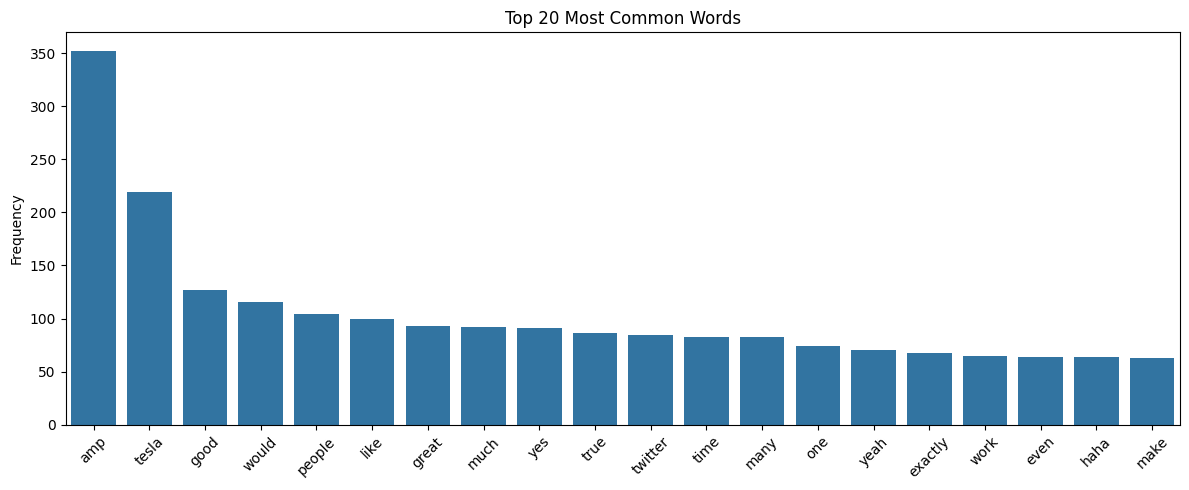

In [ ]:
words, counts = zip(*common_words)
plt.figure(figsize=(12,5))
sns.barplot(x=list(words), y=list(counts))
plt.title("Top 20 Most Common Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#merge tabels

In [ ]:
tsla.index = pd.to_datetime(tsla.index)

In [ ]:
daily_tweets['Date'] = pd.to_datetime(daily_tweets['Date'])

In [ ]:
# Merge tsla and daily_tweets using date as the key
df_merged = pd.merge(tsla,daily_tweets, left_index=True, right_on='Date', how='left')


In [ ]:
df_merged

,Close,High,Low,Open,Volume,Change,label,Date,Cleaned_Tweet
0.0,244.696671,247.330002,243.756668,244.693329,39612900,-0.566666,0.0,2021-09-01,i was in the berlin paint shop talking to th...
1.0,244.130005,246.990005,243.513336,244.833328,38331900,0.393326,1.0,2021-09-02,im fkn tryin ur welcome pls be nice to the hum...
2.0,244.523331,244.666672,241.399994,244.083328,45738300,6.449997,1.0,2021-09-03,this is obv debatable but id call anything wit...
5.0,250.973328,253.399994,246.419998,246.666672,60119400,0.316666,1.0,2021-09-07,thanks what is your favorite tea and if it doe...
6.0,251.289993,254.816666,246.923340,253.860001,56379000,0.330002,1.0,2021-09-08,that sums it up well
...,...,...,...,...,...,...,...,...,...
330.0,297.096680,303.646667,296.500000,297.563324,57259800,-1.026672,0.0,2022-08-24,i would gladly obey their commands but i cant ...
331.0,296.070007,302.959991,291.600006,302.359985,53230000,-7.980011,0.0,2022-08-25,livestream of big news in about an hour releas...
332.0,288.089996,302.000000,287.470001,297.429993,57163900,-3.269989,0.0,2022-08-26,some are indeed sadly antihuman countries shou...
335.0,284.820007,287.739990,280.700012,282.829987,41864700,-7.119995,0.0,2022-08-29,it will grow by at least to meters over time f...


#Tweets Statistic data


In [ ]:
df_filtered = elon_df.copy()

In [ ]:
df_filtered['tweet_length']=elon_df['Cleaned_Tweet'].apply(len)

In [ ]:
df_filtered

,Date Created,Tweets,Date,Cleaned_Tweet,tweet_length
80,2022-08-31 15:39:27+00:00,@ChrisZheng001 I intend to do so as soon as po...,2022-08-31,i intend to do so as soon as possible,37
81,2022-08-31 15:16:57+00:00,@teslaownersSV 🤣,2022-08-31,,0
82,2022-08-31 15:13:23+00:00,"@SciGuySpace Yeah, aiming for up to 100 flight...",2022-08-31,yeah aiming for up to flights next year,39
83,2022-08-31 15:06:53+00:00,Now launching every ~5 days,2022-08-31,now launching every days,24
84,2022-08-30 22:52:58+00:00,@WholeMarsBlog @jonbbc @aelluswamy 10.69.2 goe...,2022-08-30,goes out to k owners next week,30
...,...,...,...,...,...
3737,2021-09-01 16:46:52+00:00,@DJSnM @thesheetztweetz @johnkrausphotos @Lyla...,2021-09-01,technically data packets do not need to touch ...,126
3738,2021-09-01 16:42:32+00:00,@DJSnM @thesheetztweetz @johnkrausphotos @Lyla...,2021-09-01,our satellites launching in next few months ha...,132
3739,2021-09-01 16:21:41+00:00,@thesheetztweetz Filing legal actions against ...,2021-09-01,filing legal actions against spacex is actuall...,64
3740,2021-09-01 16:13:33+00:00,@SciGuySpace He should consider spending some ...,2021-09-01,he should consider spending some money on actu...,97


In [ ]:
df_filtered['tweet_length'].max()

275

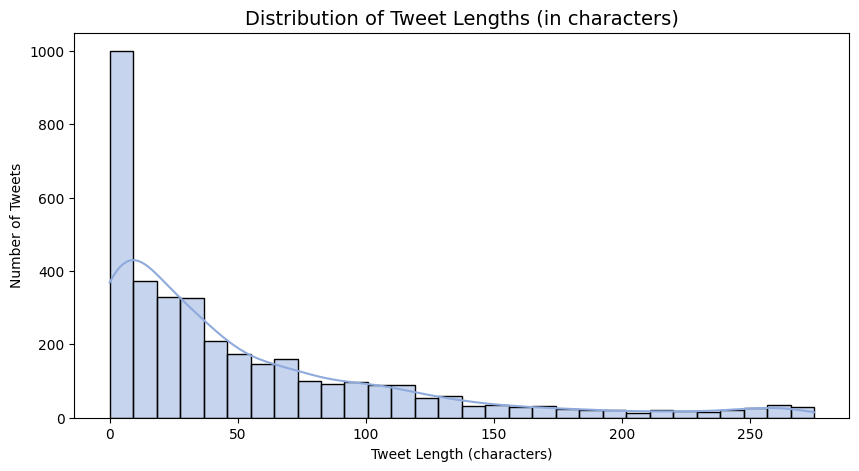

In [ ]:
# Plot histogram of tweet lengths
plt.figure(figsize=(10,5))
sns.histplot(df_filtered['tweet_length'], bins=30, kde=True,color='#8FAADC')
plt.title("Distribution of Tweet Lengths (in characters)", fontsize=14)
plt.xlabel("Tweet Length (characters)")
plt.ylabel("Number of Tweets")
plt.show()

<ipython-input-320-6cc6a724ec7e>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_filtered['month'] = df_filtered['Date Created'].dt.to_period('M')


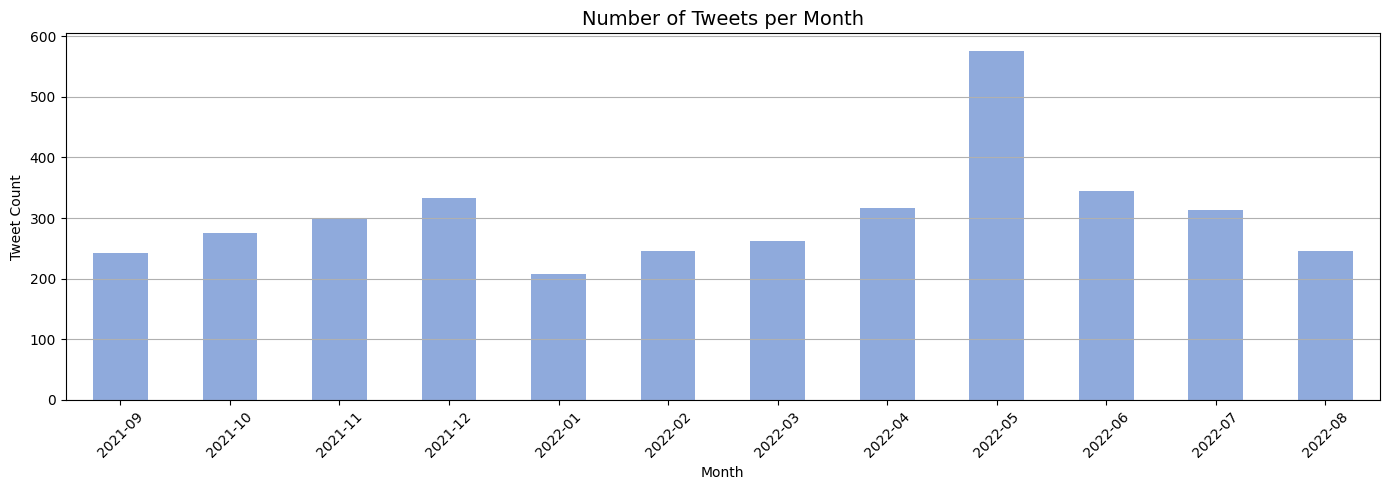

In [ ]:
df_filtered['Date Created'] = pd.to_datetime(df_filtered['Date Created'])
df_filtered['month'] = df_filtered['Date Created'].dt.to_period('M')

monthly_counts = df_filtered.groupby('month').size()

# Plot monthly tweet counts
monthly_counts.plot(kind='bar', figsize=(14,5), color='#8FAADC')
plt.title("Number of Tweets per Month", fontsize=14)
plt.ylabel("Tweet Count")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

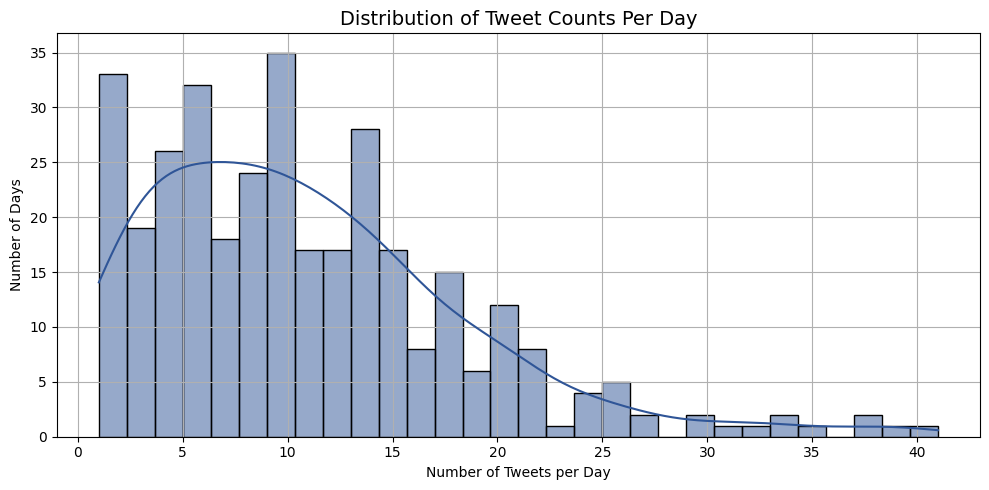

In [ ]:
# Count the number of tweets per day
tweets_per_day = df_filtered['Date Created'].dt.date.value_counts().sort_index()

# Plot histogram of tweet frequency per day
plt.figure(figsize=(10,5))
sns.histplot(tweets_per_day, bins=30, kde=True, color='#2F5597')
plt.title("Distribution of Tweet Counts Per Day", fontsize=14)
plt.xlabel("Number of Tweets per Day")
plt.ylabel("Number of Days")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Count tweets per day
tweets_per_day = df_filtered['Date Created'].dt.date.value_counts().sort_index()

# Display basic statistics
print("Tweet Frequency Per Day Statistics:")
print(f" Mean: {tweets_per_day.mean():.2f}")
print(f" Median: {tweets_per_day.median()}")
print(f" Max: {tweets_per_day.max()}")
print(f" Min: {tweets_per_day.min()}")
print(f" Std Dev: {tweets_per_day.std():.2f}")


Tweet Frequency Per Day Statistics:
 Mean: 10.83
 Median: 10.0
 Max: 41
 Min: 1
 Std Dev: 7.51


#SANTIMENT - tweets

In [ ]:
nltk.download('punkt_tab')#('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def process_for_sentiment(text):
    if pd.isnull(text):
        return "Nan"
    text = str(text)  #string
    words = word_tokenize(text)
    words = [Word(w).lemmatize() for w in words if w not in stop_words]
    return ' '.join(words)

elon_df['Processed_Tweet'] = elon_df['Cleaned_Tweet'].apply(process_for_sentiment)

In [ ]:
elon_df

,Date Created,Tweets,Date,Cleaned_Tweet,Processed_Tweet
80,2022-08-31 15:39:27+00:00,@ChrisZheng001 I intend to do so as soon as po...,2022-08-31,i intend to do so as soon as possible,intend soon possible
81,2022-08-31 15:16:57+00:00,@teslaownersSV 🤣,2022-08-31,,
82,2022-08-31 15:13:23+00:00,"@SciGuySpace Yeah, aiming for up to 100 flight...",2022-08-31,yeah aiming for up to flights next year,yeah aiming flight next year
83,2022-08-31 15:06:53+00:00,Now launching every ~5 days,2022-08-31,now launching every days,launching every day
84,2022-08-30 22:52:58+00:00,@WholeMarsBlog @jonbbc @aelluswamy 10.69.2 goe...,2022-08-30,goes out to k owners next week,go k owner next week
...,...,...,...,...,...
3737,2021-09-01 16:46:52+00:00,@DJSnM @thesheetztweetz @johnkrausphotos @Lyla...,2021-09-01,technically data packets do not need to touch ...,technically data packet need touch regular int...
3738,2021-09-01 16:42:32+00:00,@DJSnM @thesheetztweetz @johnkrausphotos @Lyla...,2021-09-01,our satellites launching in next few months ha...,satellite launching next month intersatellite ...
3739,2021-09-01 16:21:41+00:00,@thesheetztweetz Filing legal actions against ...,2021-09-01,filing legal actions against spacex is actuall...,filing legal action spacex actually fulltime job
3740,2021-09-01 16:13:33+00:00,@SciGuySpace He should consider spending some ...,2021-09-01,he should consider spending some money on actu...,consider spending money actual lunar lander ha...


In [ ]:
elon_df.isna().sum()

,0
Date Created,0
Tweets,0
Date,0
Cleaned_Tweet,0
Processed_Tweet,0


In [ ]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(elon_df["Processed_Tweet"])
word_index = tokenizer.word_index
seqs = tokenizer.texts_to_sequences(elon_df["Processed_Tweet"])
padded = pad_sequences(seqs, padding='pre')


In [ ]:
len(padded[0])

35

In [ ]:
list(word_index.items())[:2]

[('<OOV>', 1), ('amp', 2)]

In [ ]:
MAXLEN = len(padded[0])

In [ ]:
X = padded
y = np.expand_dims(X, axis=-1)

In [ ]:


model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=64),
    GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # binary
])

model.compile(optimizer='adam', loss='mse')


sentiment_scores = model.predict(padded).flatten()
elon_df['sentiment_score'] = sentiment_scores


115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
elon_df

,Date Created,Tweets,Date,Cleaned_Tweet,Processed_Tweet,sentiment_score
80,2022-08-31 15:39:27+00:00,@ChrisZheng001 I intend to do so as soon as po...,2022-08-31,i intend to do so as soon as possible,intend soon possible,0.495031
81,2022-08-31 15:16:57+00:00,@teslaownersSV 🤣,2022-08-31,,,0.494016
82,2022-08-31 15:13:23+00:00,"@SciGuySpace Yeah, aiming for up to 100 flight...",2022-08-31,yeah aiming for up to flights next year,yeah aiming flight next year,0.495056
83,2022-08-31 15:06:53+00:00,Now launching every ~5 days,2022-08-31,now launching every days,launching every day,0.494805
84,2022-08-30 22:52:58+00:00,@WholeMarsBlog @jonbbc @aelluswamy 10.69.2 goe...,2022-08-30,goes out to k owners next week,go k owner next week,0.494121
...,...,...,...,...,...,...
3737,2021-09-01 16:46:52+00:00,@DJSnM @thesheetztweetz @johnkrausphotos @Lyla...,2021-09-01,technically data packets do not need to touch ...,technically data packet need touch regular int...,0.495853
3738,2021-09-01 16:42:32+00:00,@DJSnM @thesheetztweetz @johnkrausphotos @Lyla...,2021-09-01,our satellites launching in next few months ha...,satellite launching next month intersatellite ...,0.496770
3739,2021-09-01 16:21:41+00:00,@thesheetztweetz Filing legal actions against ...,2021-09-01,filing legal actions against spacex is actuall...,filing legal action spacex actually fulltime job,0.495393
3740,2021-09-01 16:13:33+00:00,@SciGuySpace He should consider spending some ...,2021-09-01,he should consider spending some money on actu...,consider spending money actual lunar lander ha...,0.495519


In [ ]:
daily_sentiment = elon_df.groupby("Date")["sentiment_score"].median().reset_index()


In [ ]:
daily_sentiment

,Date,sentiment_score
0,2021-09-01,0.494736
1,2021-09-02,0.495050
2,2021-09-03,0.495578
3,2021-09-04,0.494697
4,2021-09-06,0.494473
...,...,...
333,2022-08-27,0.494635
334,2022-08-28,0.494911
335,2022-08-29,0.495833
336,2022-08-30,0.495008


In [ ]:
#merge
df_merged["Date"] = pd.to_datetime(df_merged["Date"])
daily_sentiment["Date"] = pd.to_datetime(daily_sentiment["Date"])


df_merged = df_merged.merge(daily_sentiment, on="Date", how="left")


df_merged["sentiment_score"].fillna(0.5, inplace=True)


<ipython-input-336-33b123fa5727>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged["sentiment_score"].fillna(0.5, inplace=True)


In [ ]:
df_merged

,Close,High,Low,Open,Volume,Change,label,Date,Cleaned_Tweet,sentiment_score
0,244.696671,247.330002,243.756668,244.693329,39612900,-0.566666,0.0,2021-09-01,i was in the berlin paint shop talking to th...,0.494736
1,244.130005,246.990005,243.513336,244.833328,38331900,0.393326,1.0,2021-09-02,im fkn tryin ur welcome pls be nice to the hum...,0.495050
2,244.523331,244.666672,241.399994,244.083328,45738300,6.449997,1.0,2021-09-03,this is obv debatable but id call anything wit...,0.495578
3,250.973328,253.399994,246.419998,246.666672,60119400,0.316666,1.0,2021-09-07,thanks what is your favorite tea and if it doe...,0.494736
4,251.289993,254.816666,246.923340,253.860001,56379000,0.330002,1.0,2021-09-08,that sums it up well,0.494065
...,...,...,...,...,...,...,...,...,...,...
246,297.096680,303.646667,296.500000,297.563324,57259800,-1.026672,0.0,2022-08-24,i would gladly obey their commands but i cant ...,0.494529
247,296.070007,302.959991,291.600006,302.359985,53230000,-7.980011,0.0,2022-08-25,livestream of big news in about an hour releas...,0.494646
248,288.089996,302.000000,287.470001,297.429993,57163900,-3.269989,0.0,2022-08-26,some are indeed sadly antihuman countries shou...,0.494628
249,284.820007,287.739990,280.700012,282.829987,41864700,-7.119995,0.0,2022-08-29,it will grow by at least to meters over time f...,0.495833


#Classic Models With Santiment

In [ ]:
scale_features = ['Close','High','Low','Open','Volume']
no_scale_features = ["sentiment_score"]
features_with_sent = scale_features + no_scale_features

In [ ]:
split_index = int(len(df_merged) * 0.8)
train = df_merged.iloc[:split_index]
test = df_merged.iloc[split_index:]

X_train = train[features_with_sent]
X_test = test[features_with_sent]
y_train = train['label']
y_test = test['label']


In [ ]:
scaler = StandardScaler()
X_train_scaled_part = scaler.fit_transform(X_train[scale_features])
X_test_scaled_part = scaler.transform(X_test[scale_features])

In [ ]:
X_train_scaled = np.hstack([X_train_scaled_part, X_train[no_scale_features].values])
X_test_scaled = np.hstack([X_test_scaled_part, X_test[no_scale_features].values])

In [ ]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features_with_sent, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features_with_sent, index=X_test.index)

same classic models codes

In [ ]:
df_merged[["Close", "High", "Low", "Open", "Volume", "sentiment_score"]].isna().sum()


,0
Close,0
High,0
Low,0
Open,0
Volume,0
sentiment_score,0


In [ ]:
np.isnan(X_train_scaled).sum()


,0
Close,0
High,0
Low,0
Open,0
Volume,0
sentiment_score,0


In [ ]:
#Defining models
models = {

    "Logistic Regression": LogisticRegression(max_iter=50, C=0.001, random_state=42,class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=5, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=6, min_samples_leaf=5, random_state=42),
    "SVM": SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
}


In [ ]:
print(tsla['label'].value_counts(normalize=True))

label
1.0    0.541833
0.0    0.458167
Name: proportion, dtype: float64


In [ ]:

# Initialize results list
results = []

# Loop over models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)

    # Append to results list
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "Confusion Matrix": conf
    })

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:23:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
results_df = pd.DataFrame(results).drop(columns=['Confusion Matrix'])
results_df.sort_values(by='F1-score', ascending=False)

,Model,Accuracy,Precision,Recall,F1-score
3,SVM,0.529412,0.529412,1.000000,0.692308
0,Logistic Regression,0.549020,0.543478,0.925926,0.684932
1,Random Forest,0.529412,0.533333,0.888889,0.666667
5,XGBoost,0.529412,0.548387,0.629630,0.586207
2,Decision Tree,0.549020,0.576923,0.555556,0.566038
4,KNN,0.549020,0.576923,0.555556,0.566038


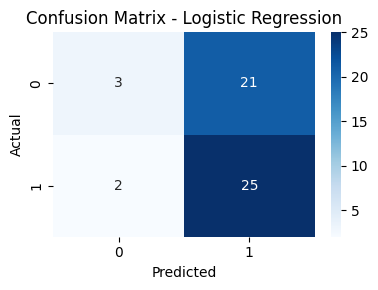

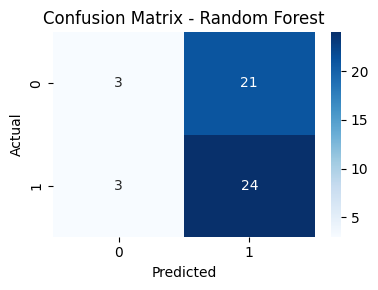

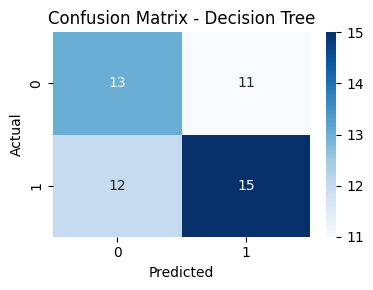

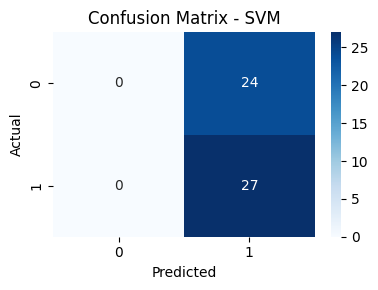

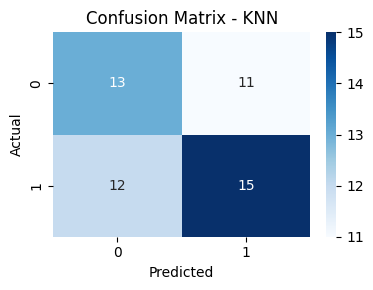

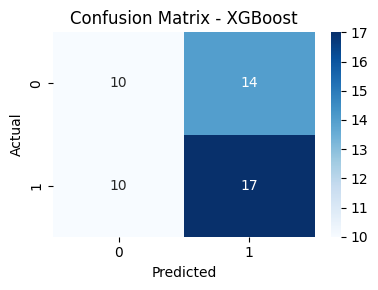

In [ ]:
for result in results:
    plt.figure(figsize=(4,3))
    sns.heatmap(result['Confusion Matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {result['Model']}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

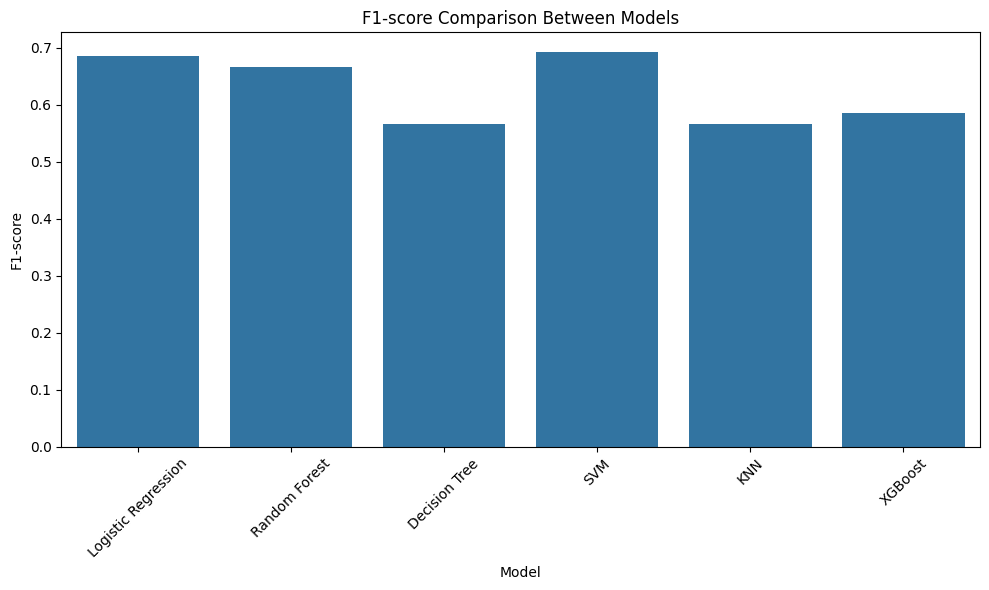

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x='Model', y='F1-score')
plt.title('F1-score Comparison Between Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#LSTM With Sentiment

In [ ]:
features_df = df_merged[["Close", "sentiment_score"]].copy()
features_df = features_df.dropna()

In [ ]:
split_index = int(len(features_df) * 0.8)

train_df = features_df.iloc[:split_index]
test_df = features_df.iloc[split_index:]


In [ ]:
scaler_close = MinMaxScaler(feature_range=(-1, 1))
scaler_sentiment = MinMaxScaler(feature_range=(-1, 1))

train_scaled = np.hstack([
    scaler_close.fit_transform(train_df[["Close"]]),
    scaler_sentiment.fit_transform(train_df[["sentiment_score"]])
])

test_scaled = np.hstack([
    scaler_close.transform(test_df[["Close"]]),
    scaler_sentiment.transform(test_df[["sentiment_score"]])
])


In [ ]:
def create_multifeature_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i + window_size][0])
    return np.array(X), np.array(y)

window_size = 12
X_train, y_train = create_multifeature_sequences(train_scaled, window_size)
X_test, y_test = create_multifeature_sequences(test_scaled, window_size)


In [ ]:
print(X_train.shape)


(188, 12, 2)


In [ ]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window_size, X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1)
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#LSTM

In [ ]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

In [ ]:
history = model.fit(
    X_train,y_train,
    validation_data=(X_test,y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2655 - val_loss: 0.1388 - learning_rate: 0.0010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2156 - val_loss: 0.1459 - learning_rate: 0.0010
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1388 - val_loss: 0.1531 - learning_rate: 0.0010
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0832 - val_loss: 0.1668 - learning_rate: 0.0010
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0739 - val_loss: 0.1670 - learning_rate: 0.0010
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0648 - val_loss: 0.1416 - learning_rate: 0.0010
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0543 - val_loss: 0.1532 - learning_rate: 5.0000e-04
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0578 - val_loss: 0.1478 - learning_rate: 5.0000e-04
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0558 - val_loss: 0.1506 - learning_rate: 5.0000e-0

In [ ]:
y_pred = model.predict(X_test)
y_pred_inv = scaler_close.inverse_transform(y_pred)
y_test_inv = scaler_close.inverse_transform(y_test.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


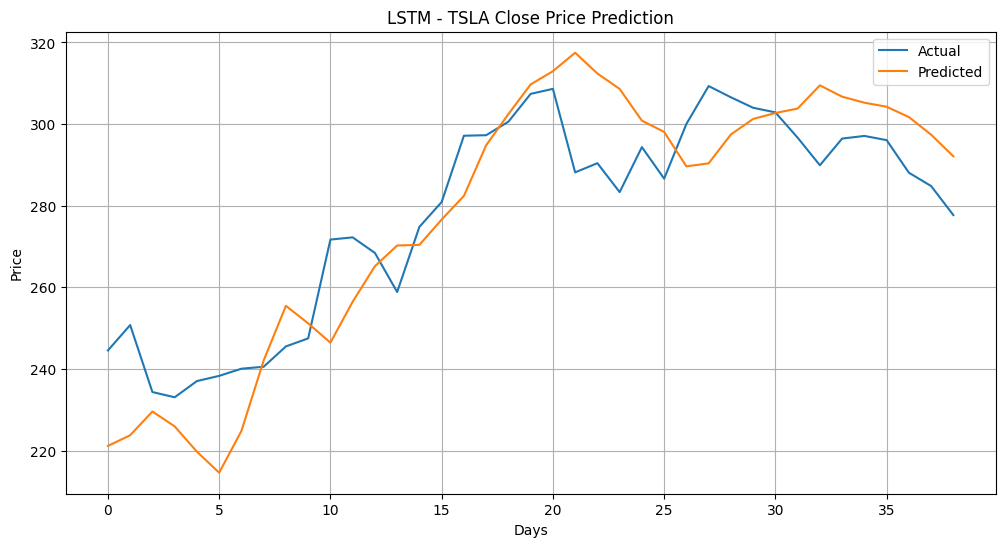

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('LSTM - TSLA Close Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

y_pred_adj = y_pred_inv[1:]


y_test_adj = y_test_inv[:-1]


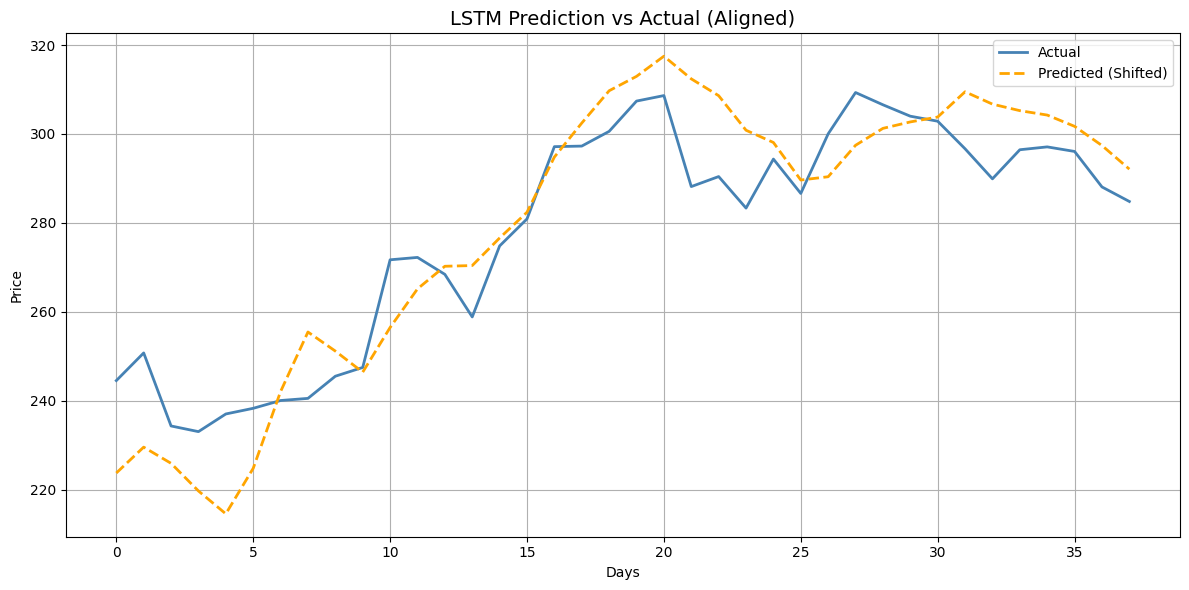

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_adj, label='Actual', color='steelblue', linewidth=2)
plt.plot(y_pred_adj, label='Predicted (Shifted)', color='orange', linestyle='--', linewidth=2)
plt.title('LSTM Prediction vs Actual (Aligned)', fontsize=14)
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


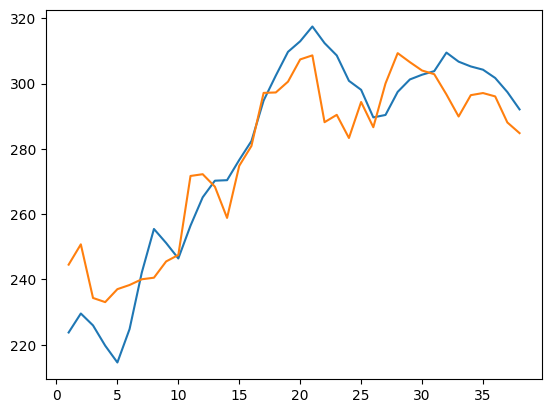

In [ ]:
plt.plot(range(1, len(y_pred_adj)+1), y_pred_adj, label='Predicted')
plt.plot(range(1, len(y_test_adj)+1), y_test_adj, label='Actual')


In [ ]:
print("Scaled y_pred range:", y_pred.min(), y_pred.max())
print("Unscaled y_pred range:", y_pred_inv.min(), y_pred_inv.max())


Scaled y_pred range: -0.9481723 0.07783624
Unscaled y_pred range: 214.58455 317.48465


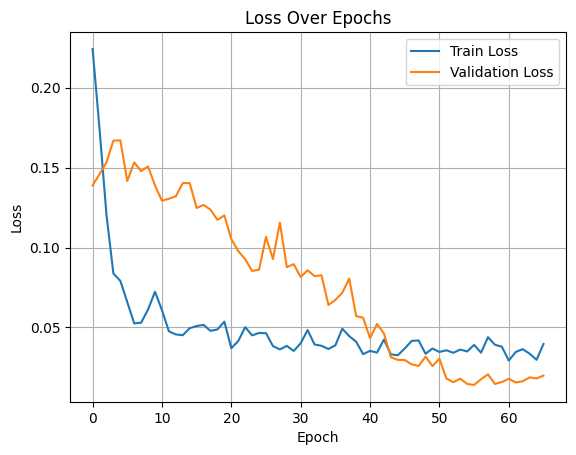

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print("Training samples:", X_train.shape[0])


Training samples: 188


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


MAE: 11.63
RMSE: 14.15
R²: 0.67
